In [1]:
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import os
import cv2

In [ ]:
# Caminho para o diretório que contém as subpastas 'comestivel' e 'venenoso'

data_dir = r'C:\GitHub\MushroomClassification\Mushrooms'

def verify_images(directory):
    for root, _, files in os.walk(directory):
        for file in files:
            file_path = os.path.join(root, file)
            try:
                img = Image.open(file_path)
                img.verify()  # Verifica a integridade da imagem
            except (IOError, SyntaxError) as e:
                print(f"Imagem corrompida detectada e removida: {file_path}")
                os.remove(file_path)

 Executa a verificação

verify_images(data_dir)

In [3]:
# Função para converter as imagens para o formato PNG
def convert_image_format(image_path, output_path):
    try:
        img = Image.open(image_path)
        img.save(output_path, 'PNG')
    except Exception as e:
        print(f"Erro ao converter a imagem {image_path}: {e}")

In [4]:
# Converter todas as imagens no diretório de forma recursiva
def convert_images_in_directory(directory):
    for root, dirs, files in os.walk(directory):
        for file in files:
            file_path = os.path.join(root, file)
            if file_path.endswith('.jpg') or file_path.endswith('.jpeg'):
                output_path = file_path.replace('.jpg', '.png').replace('.jpeg', '.png')
                convert_image_format(file_path, output_path)

In [ ]:
# Converter as imagens antes de carregar para o modelo
convert_images_in_directory(data_dir)

In [6]:
# Configuração do Data Augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.3,
    rotation_range=30,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    fill_mode = 'nearest'
)

In [7]:
# Geradores de treinamento e validação
train_generator = train_datagen.flow_from_directory(
    data_dir,  # substitua pelo caminho do diretório com as imagens
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training',
)

Found 9403 images belonging to 9 classes.


In [8]:
validation_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation',
)

Found 4023 images belonging to 9 classes.


In [9]:
# Carregar o modelo base VGG16 pré-treinado
base_model = VGG16(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
base_model.trainable = True
for layer in base_model.layers[:-4]:  # Mantenha as primeiras camadas congeladas, descongelando apenas as últimas 4
    layer.trainable = False


In [12]:
# Construir o modelo completo
model = Sequential([
    base_model,
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(9, activation='softmax')
])

In [13]:
# Compilação do modelo
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=10,  # Aumente o número de épocas
    callbacks=[early_stopping]
)

Epoch 1/10
294/294 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.2536 - loss: 2.0348

C:\Users\Uso Pessoal\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


294/294 ━━━━━━━━━━━━━━━━━━━━ 2584s 9s/step - accuracy: 0.2538 - loss: 2.0342 - val_accuracy: 0.4464 - val_loss: 1.5724
Epoch 2/10
294/294 ━━━━━━━━━━━━━━━━━━━━ 2580s 9s/step - accuracy: 0.4911 - loss: 1.4496 - val_accuracy: 0.5372 - val_loss: 1.3764
Epoch 3/10
294/294 ━━━━━━━━━━━━━━━━━━━━ 2900s 10s/step - accuracy: 0.6114 - loss: 1.1151 - val_accuracy: 0.5523 - val_loss: 1.3299
Epoch 4/10
294/294 ━━━━━━━━━━━━━━━━━━━━ 2929s 10s/step - accuracy: 0.6674 - loss: 0.9433 - val_accuracy: 0.5983 - val_loss: 1.1985
Epoch 5/10
294/294 ━━━━━━━━━━━━━━━━━━━━ 3140s 11s/step - accuracy: 0.7283 - loss: 0.7901 - val_accuracy: 0.6174 - val_loss: 1.1778
Epoch 6/10
294/294 ━━━━━━━━━━━━━━━━━━━━ 2955s 10s/step - accuracy: 0.7509 - loss: 0.7204 - val_accuracy: 0.6617 - val_loss: 1.0773
Epoch 7/10
294/294 ━━━━━━━━━━━━━━━━━━━━ 3091s 11s/step - accuracy: 0.8043 - loss: 0.5815 - val_accuracy: 0.6662 - val_loss: 1.0542
Epoch 8/10
294/294 ━━━━━━━━━━━━━━━━━━━━ 2893s 10s/step - accuracy: 0.8191 - loss: 0.5308 - val_a

In [14]:
# Avaliação
loss, accuracy = model.evaluate(validation_generator)
print(f"Acurácia: {accuracy * 100:.2f}%")


126/126 ━━━━━━━━━━━━━━━━━━━━ 829s 7s/step - accuracy: 0.6617 - loss: 1.1144
Acurácia: 66.69%


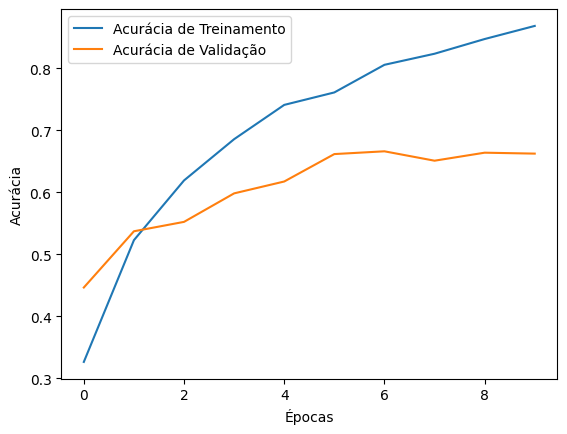

In [15]:
# Visualizando a perda e acurácia
plt.plot(history.history['accuracy'], label='Acurácia de Treinamento')
plt.plot(history.history['val_accuracy'], label='Acurácia de Validação')
plt.xlabel('Épocas')
plt.ylabel('Acurácia')
plt.legend()
plt.show()

In [18]:
def safe_load_img(image_path):
    try:
        img = load_img(image_path, target_size=(224, 224))  # Redimensionar para 224x224 (tamanho de entrada do VGG16)
        img_array = img_to_array(img)
        return img_array
    except Exception as e:
        print(f"Erro ao carregar a imagem {image_path}: {e}")
        return None

In [19]:
# Função para validar novas imagens
def validate_image(image_path):
    processed_image = safe_load_img(image_path)
    if processed_image is None:
        print("Erro ao processar a imagem.")
        return
    processed_image = np.expand_dims(processed_image, axis=0)  # Adicionar dimensão para batch
    predictions = model.predict(processed_image)
    class_index = np.argmax(predictions)  # Pega o índice da classe com maior probabilidade
    class_labels = ['Agaricus', 'Amanita', 'Boletus', 'Cortinarius', 'Entoloma', 'Hygrocybe', 'Lactarius', 'Russula', 'Suillus']
    predicted_class = class_labels[class_index]
    
    edible_classes = ['Agaricus', 'Boletus', 'Lactarius', 'Russula', 'Suillus']
    if predicted_class in edible_classes:
        print(f"A imagem é do cogumelo {predicted_class}, que é comestível.")
    else:
        print(f"A imagem é do cogumelo {predicted_class}, que é venenoso.")

In [ ]:
# Insira o caminho da imagem para teste

img_path = r'C:\GitHub\MushroomClassification\Mushroom dataset\cnn\Poisonous\img220.jpg'
validate_image(img_path)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 977ms/step
A imagem é do cogumelo Amanita, que é venenoso.
